project2ba
================
Scherbakova Anna and Varvara Vasyukova (team Mentally Unstable)
08 12 2021

<https://docs.google.com/document/d/1rCxsDlO_WPbgE51wU-W2Pg4fKMJNdVWw-rtmxlyM5aY/edit?usp=sharing>
link to shared document

# Main results

The **aim** of this report is to describe the situation about customers
of Sber.Market and build predictive models that will help to assess the
situation in the future. The existing system of Sber.Market fails to
retain customers and to meet their needs.

The report **provides** several plots for understanding the current
situation, and in order to identify key metrics for customer churn and
satisfaction. Then the linear and logistic regression models are built
in order to predict customers’ churn and satisfaction.

The **results** suggest that right now women and people aged 25-34
prevail as audience of Sber.Market. App is more popular than website and
leads to higher satisfaction, however, older people prefer the site.
However, the service is losing their regular buyers, number of
dissatisfied customers and the churn rate are extremely high. Current
churn rate is 25%.

**Limitations** are so that the dataset lacks date data, which would
really help to identify LTV and compute Survival Analysis.

### Uploading all data files

### Merge all together

# Exploratory Data Analysis

### Demographics

In [ ]:
library(prettydoc)
library(nnet)
library(skimr)
library(dplyr)
library(psych)
library(ggplot2)
library(ggpubr)
library(patchwork)
library(jtools)
library(tidyr)
library(tidyverse)
library(tidymodels)
library(rsample)
library(caret)
library(MLmetrics)
library(scales)

### Uploading all data files

In [ ]:
exp <- read_csv("./data/CustomerExperience.csv",show_col_types = FALSE)
info <- read_csv("./data/CustomerInfo.csv",show_col_types = FALSE)
info1 <- distinct(info, user_id, .keep_all = TRUE)
del <- read_csv("./data/CustomerDelivery.csv",show_col_types = FALSE)
ord <- read_csv("./data/OrdersFinance.csv",show_col_types = FALSE)

### Merge all together

In [3]:
one <- merge(exp, info1, by = "user_id", all = T)
two <- merge(del, ord, by = "user_id", all = T)
sber1 <- merge(one, two, by = "user_id", all = T)
sberdat <- select(sber1, -"...1.x.x", - "...1.y.x", - "...1.x.y", -"...1.y.y")
sber<- na.omit(sberdat)
summary(sber)

    user_id           CE_id             mean_rate     satisfaction      
 Min.   :   5619   Length:6037        Min.   :0.000   Length:6037       
 1st Qu.:1068602   Class :character   1st Qu.:1.670   Class :character  
 Median :1628281   Mode  :character   Median :3.120   Mode  :character  
 Mean   :1562777                      Mean   :2.828                     
 3rd Qu.:2146773                      3rd Qu.:4.120                     
 Max.   :2916667                      Max.   :5.000                     
   avg_check       timediff_order     gender           age_group        
 Min.   :  15.39   Min.   :  2.0   Length:6037        Length:6037       
 1st Qu.:  98.24   1st Qu.: 55.0   Class :character   Class :character  
 Median : 121.95   Median :101.0   Mode  :character   Mode  :character  
 Mean   : 138.68   Mean   :104.2                                        
 3rd Qu.: 155.60   3rd Qu.:141.0                                        
 Max.   :2202.74   Max.   :242.0                   

# Exploratory Data Analysis

### Demographics

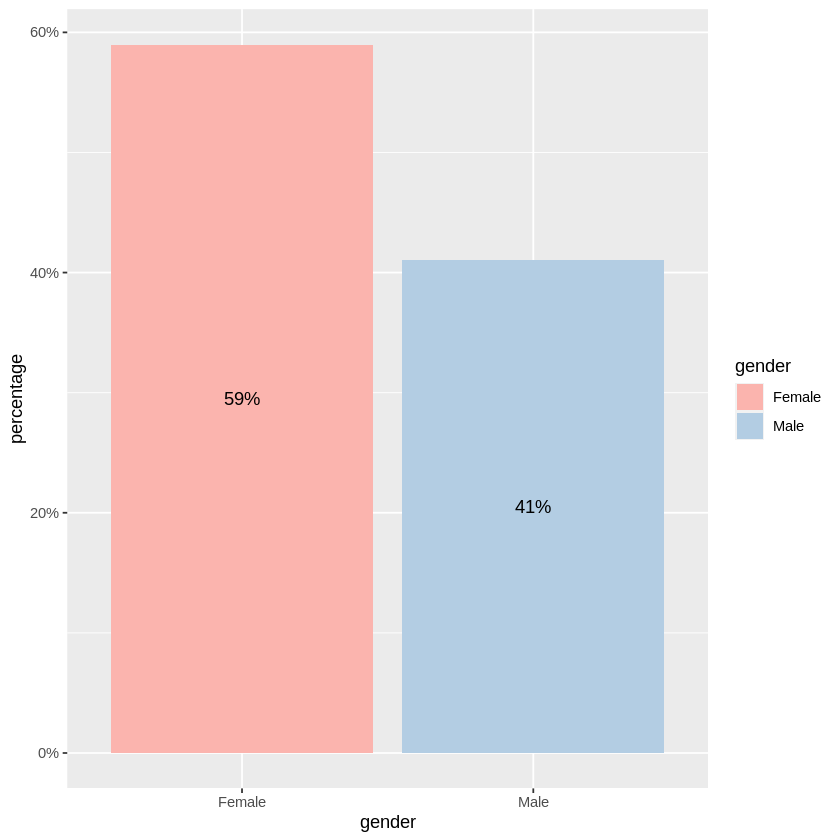

In [4]:
genders <- sber %>% group_by(gender) %>% # too simple, useless
dplyr :: summarise(count = n()) %>%
mutate(percentage = count/sum(count))

ggplot(genders, aes(gender,percentage, fill = gender)) +
geom_bar(stat='identity') +
scale_y_continuous(labels = scales::percent) +
scale_fill_brewer(palette = "Pastel1", labels= c("Женщина"="Female","Мужчина"="Male")) +
scale_color_brewer(palette = "Pastel1",
labels= c("Женщина"="Female","Мужчина"="Male")) +
scale_x_discrete(labels= c("Женщина"="Female","Мужчина"="Male")) +
geom_text(aes(label=scales::percent(percentage)), position = position_stack(vjust = .5))

This graph shows the percentage of women to men among the company's customers. So, Slightly more than half (59%) of women, while 41% of men are among the customers of the Sber.Market.

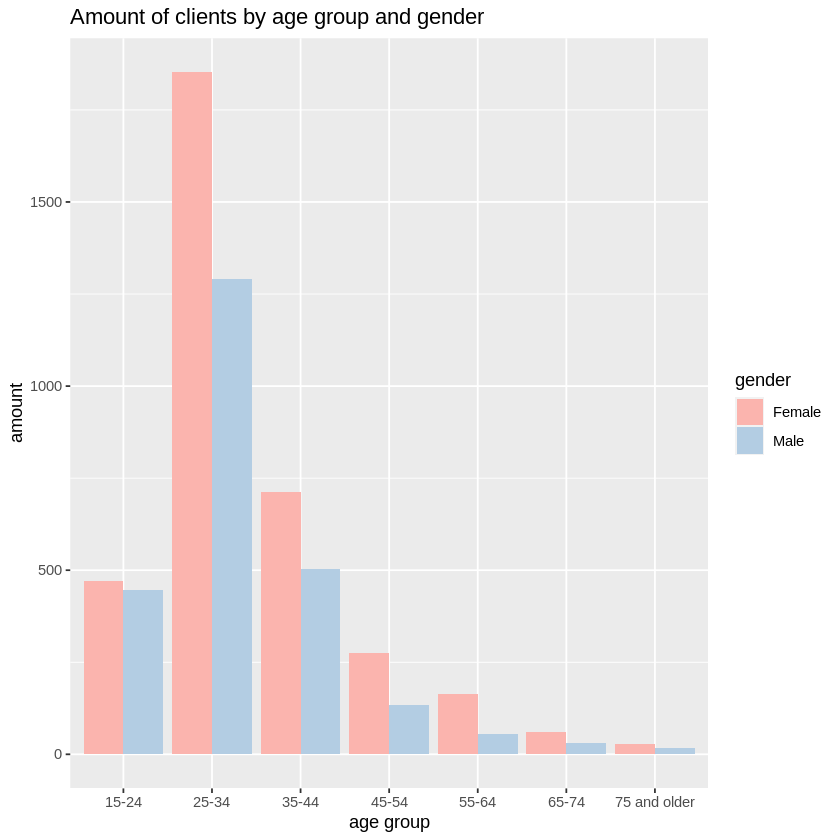

In [5]:
ggplot(sber, # better, 2 in 1 
aes(x = age_group,
fill = gender)) +
geom_bar(position = "dodge") +
scale_fill_brewer(palette = "Pastel1", labels= c("Женщина"="Female","Мужчина"="Male")) +
scale_color_brewer(palette = "Pastel1",
labels= c("Женщина"="Female","Мужчина"="Male")) +
scale_x_discrete(labels= c("15-24","25-34", "35-44", "45-54", "55-64", "65-74", "75 and older" )) +
xlab("age group") + ylab("amount") +
ggtitle("Amount of clients by age group and gender")

This graph shows that there are significantly more women than men among the company's clients. Also, the service is more often used by age groups 15-24, 25-34 and 35-44 years old. However, the number of clients among the age group 25-34 years old significantly predominates.

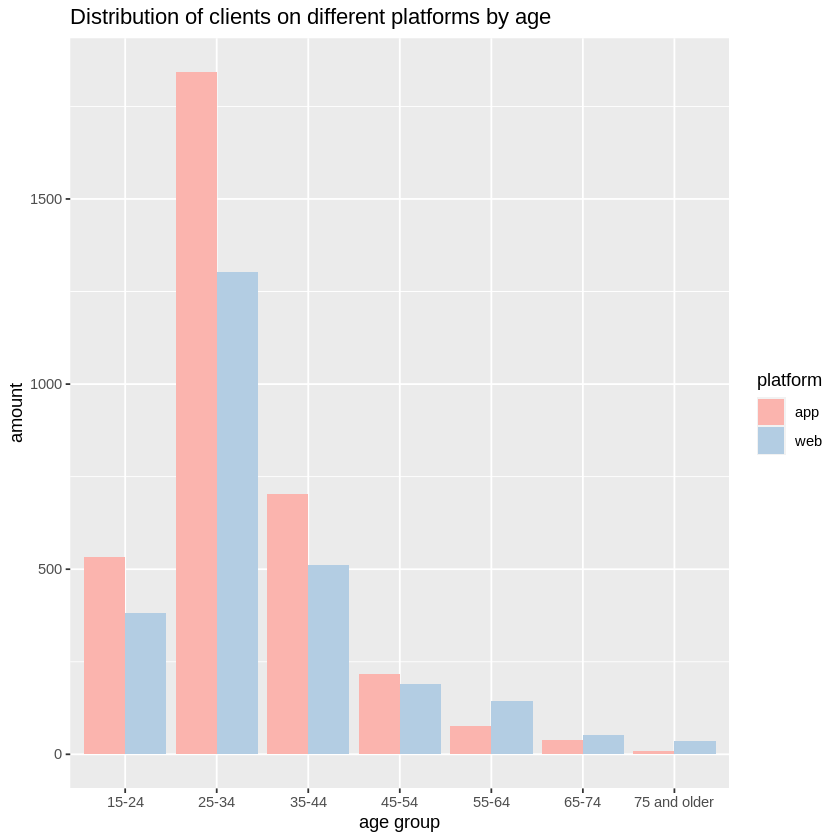

In [6]:
ggplot(sber,
aes(age_group,
fill = platform)) +
geom_bar(position = "dodge") +
scale_fill_brewer(palette = "Pastel1") +
scale_color_brewer(palette = "Pastel1") +
scale_x_discrete(labels= c("15-24","25-34", "35-44", "45-54", "55-64", "65-74", "75 and older" )) +
xlab("age group") + ylab("amount") +
ggtitle("Distribution of clients on different platforms by age")

We also decided to consider how age groups are distributed by platforms. In general, we can conclude that the appl is more popular among users. Although starting with the age group 45-54 and older, the prevalence of the application is falling. That is, older users prefer the web version of the service.

### Active/non-active users

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



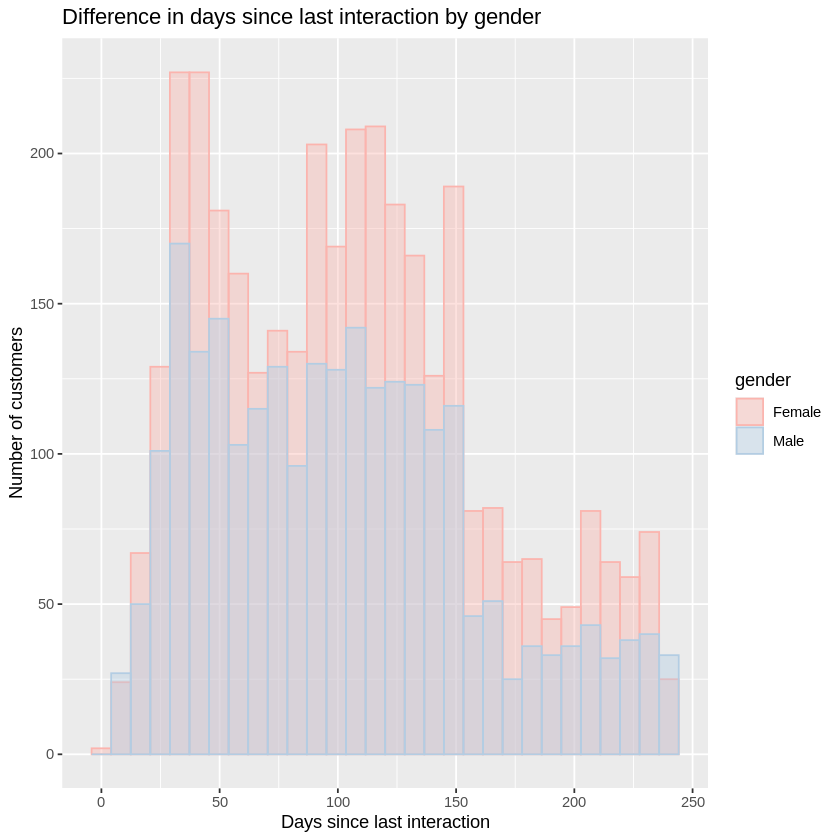

In [7]:
a <- ggplot(sber, aes(x = timediff_order))
a + geom_histogram(aes(color = gender, fill = gender),
                         alpha = 0.4, position = "identity") +
  scale_fill_brewer(palette = "Pastel1",
                    labels = c("Female", "Male")) +
  scale_color_brewer(palette = "Pastel1",
                     labels = c("Female", "Male")) +
  labs(title = "Difference in days since last interaction by gender",
       x = "Days since last interaction",
       y = "Number of customers") 

Here is the plot that shows how many customers of each gender has been inactive for a certain number of days. We can see that the tendencies are pretty much the same for both genders. Most of the customers have been inactive for 90 to 150 days. A bit less customers have been inactive for less than 50 days. But we can see that almost a third of all customers haven't interacted with the service for more than 150 days. 

### Satisfaction

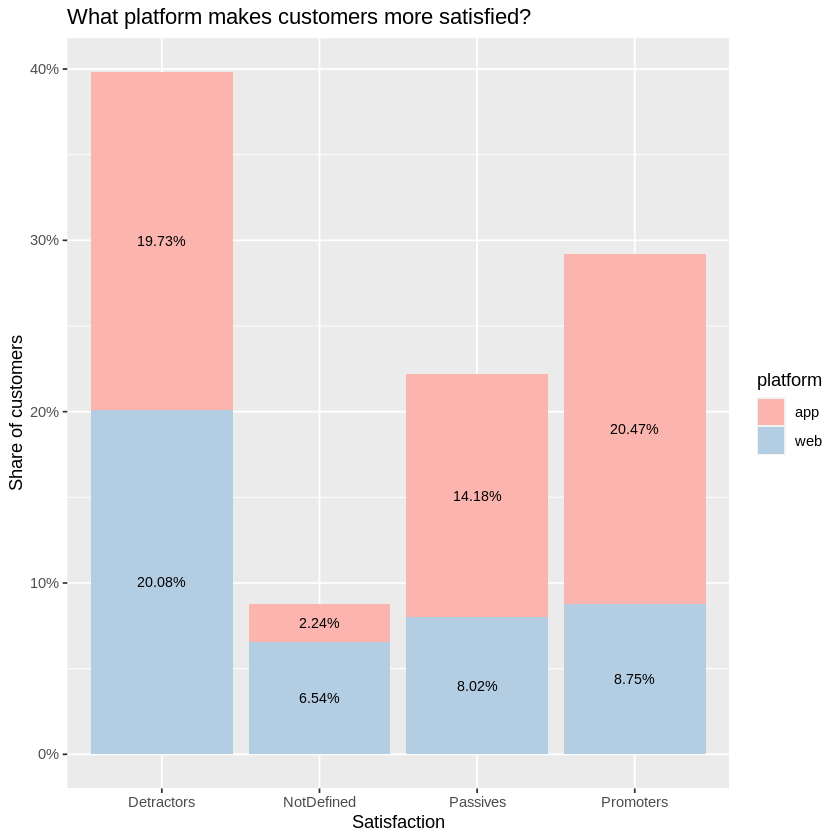

In [8]:
sberplat <- sber %>%
  dplyr :: count(satisfaction, platform) %>%
  mutate(pct = n / sum(n),
         pct_label = scales::percent(pct))


ggplot(sberplat, aes(x= satisfaction, fill = platform, y = pct)) +
  geom_col() +
  geom_text(aes(label=scales::percent(pct)),size = 3, position = position_stack(vjust = 0.5)) +
  scale_y_continuous(labels = scales::percent_format())+
    scale_fill_brewer(palette = "Pastel1") + 
  labs(title = "What platform makes customers more satisfied?",
       x = "Satisfaction",
       y = "Share of customers")

Most 'promoters' use the app, and a little bit more 'detractors' prefer the website. Thus, platform is rather important for users' satisfaction.

### Percentage of customer fulfilment (by NPS)

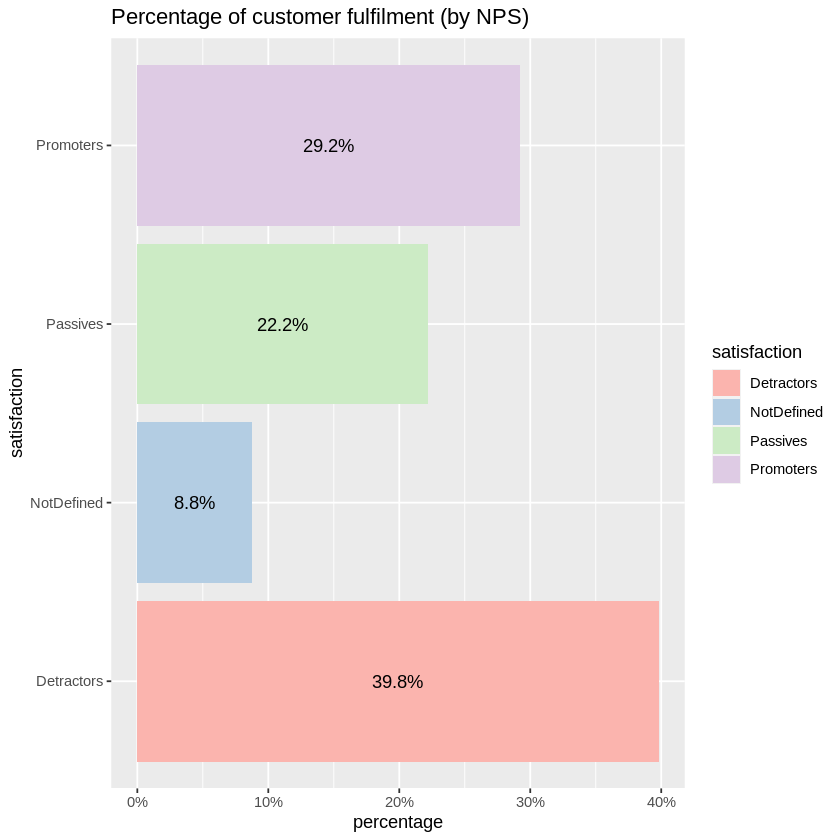

In [9]:
satis <- sber %>% group_by(satisfaction) %>%
dplyr:: summarize(count = n()) %>%
mutate(percentage = count/sum(count))

ggplot(satis, aes(satisfaction, percentage, fill = satisfaction)) +
geom_bar(stat='identity') + coord_flip() +
scale_y_continuous(labels = scales::percent) +
scale_fill_brewer(palette = "Pastel1") +
scale_color_brewer(palette = "Pastel1") +
geom_text(aes(label=scales::percent(percentage)), position = position_stack(vjust = .5)) +
ggtitle("Percentage of customer fulfilment (by NPS)")

According of this plot of the percentage of customer satisfaction by NPS, we can conclude that the company has a lot of detractors at the moment. Detractors are customers who are dissatisfied who are less likely to recommend your company to. In addition, these are customers who are most likely to churn.

### RFM

In [10]:
sber$frequency <- sber$num_orders
summary(sber$frequency)

sber$monetary <- sber$avg_check
summary(sber$monetary)

sber$recency <- Hmisc::cut2(sber$timediff_order, g = 5)
table(sber$recency)

sber$frequency_d <- Hmisc::cut2(sber$frequency, g = 5)
table(sber$frequency_d)
sber$monetary <- Hmisc::cut2(sber$avg_check, g = 5)
table(sber$monetary)

levels(sber$recency) <- c(5:1)
table(sber$recency)

levels(sber$frequency_d) <- c(1:5)
table(sber$frequency_d)

levels(sber$monetary) <- c(1:5)
table(sber$monetary)

library(tidyverse)
sber <- sber %>% 
  mutate(rfm = paste0(recency,frequency_d,monetary)) 
head(sber)

sber %>% 
  group_by(rfm) %>% 
  dplyr::summarise(n = n())

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00    5.00    9.00   11.57   15.00  174.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15.39   98.24  121.95  138.68  155.60 2202.74 


[  2, 48) [ 48, 85) [ 85,116) [116,152) [152,242] 
     1234      1194      1199      1242      1168 


[ 2,  5) [ 5,  8) [ 8, 12) [12, 18) [18,174] 
    1379     1242     1227     1042     1147 


[ 15.4,  93) [ 93.0, 112) [112.4, 133) [133.3, 166) [166.3,2203] 
        1212         1203         1208         1209         1205 


   5    4    3    2    1 
1234 1194 1199 1242 1168 


   1    2    3    4    5 
1379 1242 1227 1042 1147 


   1    2    3    4    5 
1212 1203 1208 1209 1205 

,user_id,CE_id,mean_rate,satisfaction,avg_check,timediff_order,gender,age_group,city,phone_id,⋯,os,dw_id,savings,spendings,num_orders,frequency,monetary,recency,frequency_d,rfm
,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<chr>
1,5619,CE_4720,0.00,NotDefined,122.935,210,Женщина,45-54,Москва,58953,⋯,windows,dw_4720,2202.30,9806.16,7,7,3,1,2,123
2,7216,CE_4110,0.00,NotDefined,173.410,97,Женщина,25-34,Москва,48456,⋯,android,dw_4110,154.71,5941.84,7,7,5,3,2,325
3,8699,CE_1790,3.33,Passives,120.385,42,Женщина,15-24,Москва,221634,⋯,ios,dw_1790,1157.48,10710.42,3,3,3,5,1,513
4,12439,CE_2500,2.14,Detractors,132.135,113,Женщина,25-34,Московская Область,298302,⋯,ios,dw_2500,2811.25,9195.59,7,7,3,3,2,323
5,18754,CE_1993,4.33,Promoters,304.590,105,Мужчина,25-34,Москва,240359,⋯,ios,dw_1993,4179.66,18044.99,15,15,5,3,4,345
6,21149,CE_2771,4.35,Promoters,192.520,227,Мужчина,55-64,Московская Область,33024,⋯,ios,dw_2771,720.90,6143.74,17,17,5,1,4,145


rfm,n
<chr>,<int>
111,9
112,9
113,7
114,9
115,18
121,30
122,19
123,27
124,33


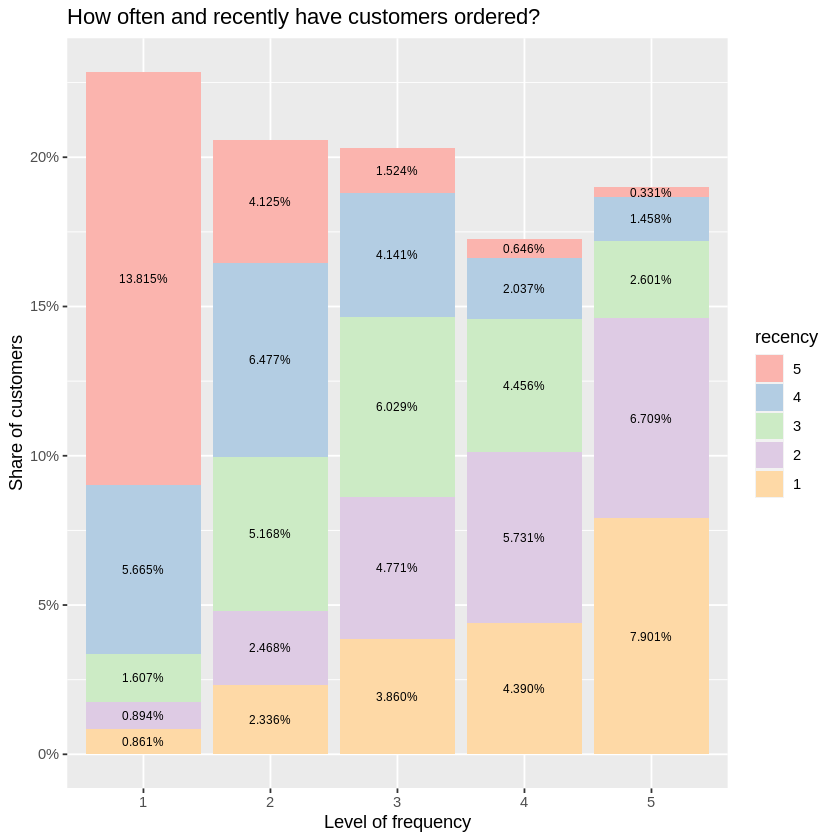

In [11]:
sbersum <- sber %>%
  count(frequency_d, recency) %>%
  mutate(pct = n / sum(n),
         pct_label = scales::percent(pct))

ggplot(sbersum, aes(x= frequency_d, fill = recency, y = pct)) +
  geom_col() +
  geom_text(aes(label=scales::percent(pct)),size = 2.5, position = position_stack(vjust = 0.5)) +
  scale_y_continuous(labels = scales::percent_format())+
    scale_fill_brewer(palette = "Pastel1") + 
  labs(title = "How often and recently have customers ordered?",
       x = "Level of frequency",
       y = "Share of customers") 

About 20% of customers that very rarely order things are quite recent, which means that they probably tend to order many things at once, but rarely.
And almost 15% of customers that order frequently have not ordered anything recently, so it means that the service is losing regular buyers.

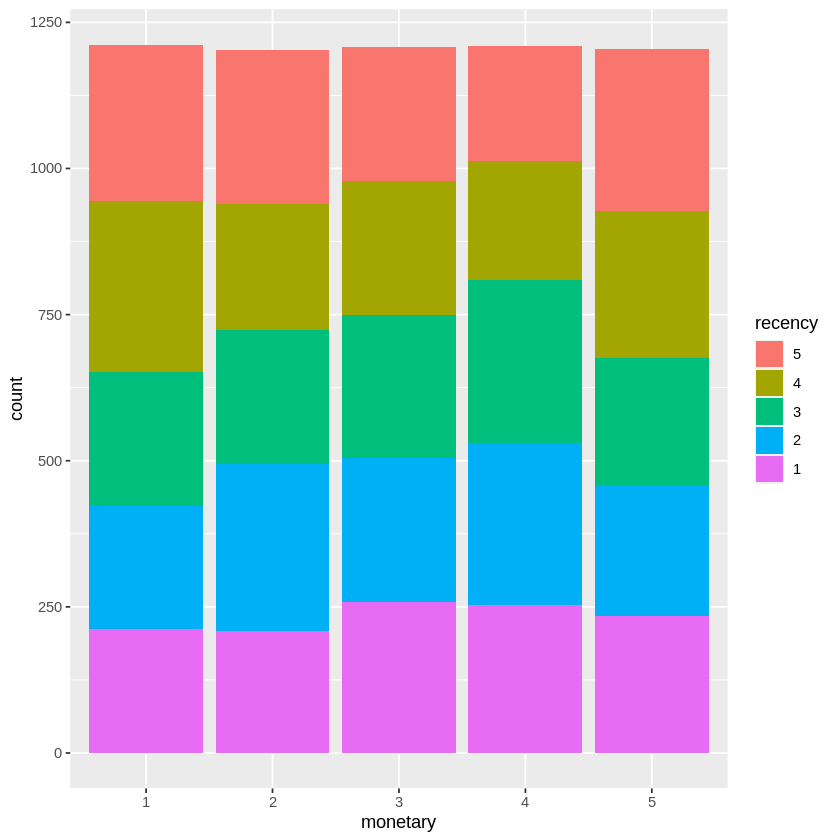

In [12]:
ggplot(sber, 
       aes(x = monetary, 
           fill = recency)) + 
  geom_bar(position = "stack")  

Correlation between recency of customers and their monetary weight showed no significant result. 

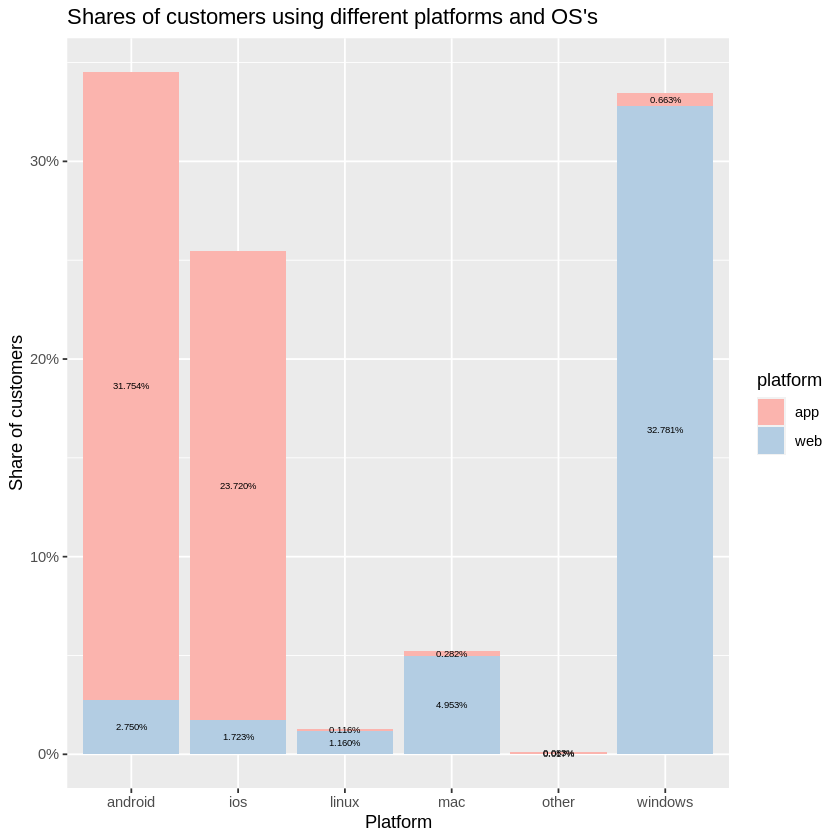

In [13]:
sberos <- sber %>%
  count(os, platform) %>%
  mutate(pct = n / sum(n),
         pct_label = scales::percent(pct))


ggplot(sberos, aes(x= os, fill = platform, y = pct)) +
  geom_col() +
  geom_text(aes(label=scales::percent(pct)),size = 2, position = position_stack(vjust = 0.5)) +
  scale_y_continuous(labels = scales::percent_format())+
    scale_fill_brewer(palette = "Pastel1") + 
  labs(title = "Shares of customers using different platforms and OS's",
       x = "Platform",
       y = "Share of customers") 

The result is logical, most smartphone users prefer the app over website, and PC users prefer website, as probably the app for PC does not exist or is inconvenient.

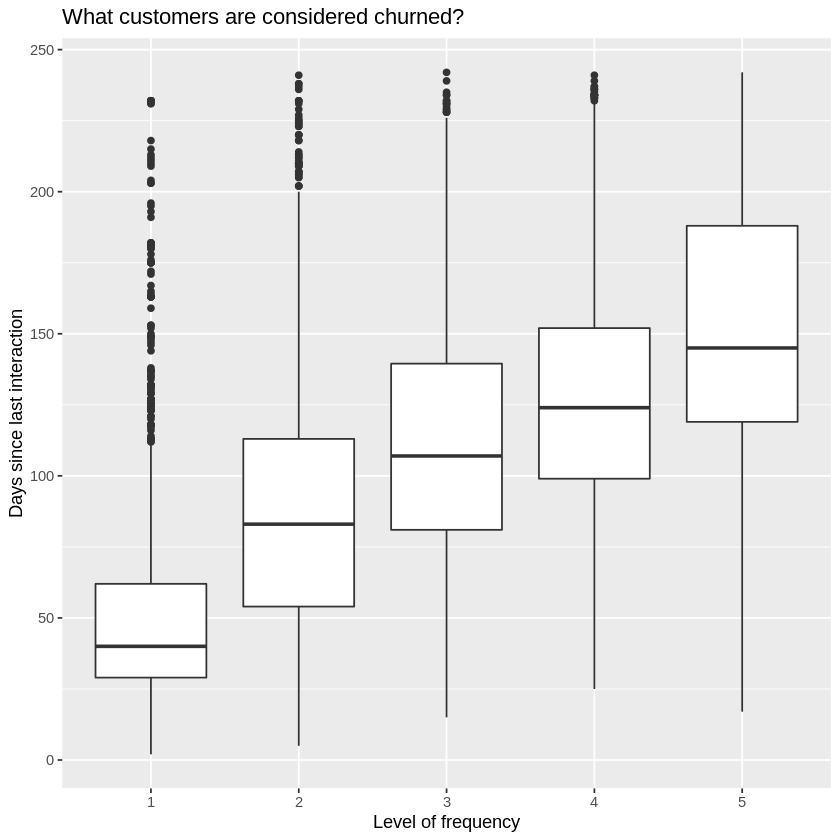

In [14]:
ggplot(sber, aes(x = frequency_d, y = timediff_order)) +
  geom_boxplot() +
  scale_fill_brewer(palette="Pastel1") +
  scale_color_brewer(palette = "Pastel1") +
    labs(title = "What customers are considered churned?",
       x = "Level of frequency",
       y = "Days since last interaction")

We can say that regular buyers that haven't interacted for many days can be considered churned. On the plot we see that some share of customers have the highest level of frequency, but they also have the most days, more than 140 days, since last interaction. These customers most likely have churned.

Create variable for churned customers:

In [15]:
sber$churned <- ifelse(sber$timediff_order > 150, "yes", "no")
sberlog <- select(sber, -user_id, -CE_id, -phone_id, -dw_id, -frequency, -monetary, -recency, -rfm)
head(sberlog)

,mean_rate,satisfaction,avg_check,timediff_order,gender,age_group,city,dw_kind,platform,os,savings,spendings,num_orders,frequency_d,churned
,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1,0.00,NotDefined,122.935,210,Женщина,45-54,Москва,courier,web,windows,2202.30,9806.16,7,2,yes
2,0.00,NotDefined,173.410,97,Женщина,25-34,Москва,courier,web,android,154.71,5941.84,7,2,no
3,3.33,Passives,120.385,42,Женщина,15-24,Москва,courier,app,ios,1157.48,10710.42,3,1,no
4,2.14,Detractors,132.135,113,Женщина,25-34,Московская Область,courier,app,ios,2811.25,9195.59,7,2,no
5,4.33,Promoters,304.590,105,Мужчина,25-34,Москва,courier,app,ios,4179.66,18044.99,15,4,no
6,4.35,Promoters,192.520,227,Мужчина,55-64,Московская Область,courier,app,ios,720.90,6143.74,17,4,yes


Making data standardized:

In [16]:
str(sberlog)
sberlog <- sberlog %>% 
  mutate_if(sapply(sberlog, is.character), as.factor)
str(sberlog)
sberlog <- sberlog %>% 
  mutate_if(sapply(sberlog, is.factor), as.numeric)
table(sberlog$churned)
sberlog$churned[sberlog$churned == 2] <- 0  
table(sberlog$churned)

'data.frame':	6037 obs. of  15 variables:
 $ mean_rate     : num  0 0 3.33 2.14 4.33 4.35 4.29 1 3.12 5 ...
 $ satisfaction  : chr  "NotDefined" "NotDefined" "Passives" "Detractors" ...
 $ avg_check     : num  123 173 120 132 305 ...
 $ timediff_order: num  210 97 42 113 105 227 127 94 108 106 ...
 $ gender        : chr  "Женщина" "Женщина" "Женщина" "Женщина" ...
 $ age_group     : chr  "45-54" "25-34" "15-24" "25-34" ...
 $ city          : chr  "Москва" "Москва" "Москва" "Московская Область" ...
 $ dw_kind       : chr  "courier" "courier" "courier" "courier" ...
 $ platform      : chr  "web" "web" "app" "app" ...
 $ os            : chr  "windows" "android" "ios" "ios" ...
 $ savings       : num  2202 155 1157 2811 4180 ...
 $ spendings     : num  9806 5942 10710 9196 18045 ...
 $ num_orders    : num  7 7 3 7 15 17 25 5 8 8 ...
 $ frequency_d   : Factor w/ 5 levels "1","2","3","4",..: 2 2 1 2 4 4 5 2 3 3 ...
 $ churned       : chr  "yes" "no" "no" "no" ...
 - attr(*, "na.action")= 'om


   1    2 
4829 1208 


   0    1 
1208 4829 

Making data scaled:

In [17]:
range01 <- function(x){(x-min(x))/(max(x)-min(x))}
suppressPackageStartupMessages(library(plyr))
sber_scaled <- plyr::colwise(range01)(sberlog)
sber_scaled <- na.omit(sber_scaled)
head(sber_scaled)
nrow(sber_scaled)
describe(sber_scaled)

,mean_rate,satisfaction,avg_check,timediff_order,gender,age_group,city,dw_kind,platform,os,savings,spendings,num_orders,frequency_d,churned
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.000,0.3333333,0.04916463,0.8666667,0,0.5000000,0.4216867,0,1,1.0,0.0105630035,0.02386762,0.029069767,0.25,0
2,0.000,0.3333333,0.07224055,0.3958333,0,0.1666667,0.4216867,0,1,0.0,0.0007420434,0.01441197,0.029069767,0.25,1
3,0.666,0.6666667,0.04799883,0.1666667,0,0.0000000,0.4216867,0,0,0.2,0.0055516802,0.02608027,0.005813953,0.00,1
4,0.428,0.0000000,0.05337064,0.4625000,0,0.1666667,0.4337349,0,0,0.2,0.0134837412,0.02237361,0.029069767,0.25,1
5,0.866,1.0000000,0.13221280,0.4291667,1,0.1666667,0.4216867,0,0,0.2,0.0200471155,0.04402731,0.075581395,0.75,1
6,0.870,1.0000000,0.08097717,0.9375000,1,0.6666667,0.4337349,0,0,0.2,0.0034576893,0.01490600,0.087209302,0.75,0


[1] 6037

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mean_rate,1,6037,0.56553189,0.31072911,0.624000000,0.58128462,0.352858800,0,1,1,-0.35019208,-1.0118030,0.0039991836
satisfaction,2,6037,0.46943846,0.42457164,0.666666667,0.46180915,0.494200000,0,1,1,0.05152281,-1.6812856,0.0054643737
avg_check,3,6037,0.05636305,0.03806059,0.048716595,0.05101069,0.018643110,0,1,1,7.41366164,107.7044774,0.0004898521
timediff_order,4,6037,0.42591174,0.23931672,0.412500000,0.40911388,0.265632500,0,1,1,0.46051064,-0.5613808,0.0030800833
gender,5,6037,0.41013749,0.49189919,0.000000000,0.38770441,0.000000000,0,1,1,0.36530912,-1.8668584,0.0063309009
age_group,6,6037,0.23187566,0.18436336,0.166666667,0.20885945,0.000000000,0,1,1,1.45056229,2.7570362,0.0023728158
city,7,6037,0.48392344,0.23988378,0.433734940,0.47622658,0.321527711,0,1,1,0.19830147,-0.8246348,0.0030873815
dw_kind,8,6037,0.01159516,0.09902468,0.000000000,0.00000000,0.000000000,0,1,1,9.02951106,83.1291441,0.0012744795
platform,9,6037,0.43382475,0.49564254,0.000000000,0.41730491,0.000000000,0,1,1,0.26698391,-1.9290390,0.0063790791


# Linear regression model (satisfaction)

In [18]:
library(sjPlot)
model <- lm(satisfaction ~ platform + frequency_d, data = sber_scaled)
library(IRdisplay)
display_html(toString(tab_model(model)))

, 
 
   
 satisfaction 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 (Intercept) 
 0.49 
 0.47 – 0.51 
 <0.001 
 
 
 platform 
 -0.17 
 -0.19 – -0.15 
 <0.001 
 
 
 frequency d 
 0.11 
 0.08 – 0.14 
 <0.001 
 
 
 Observations 
 6037 
 
 
 R 2 / R 2 adjusted 
 0.047 / 0.046 
 

 
, 
 
 

 
 
 
 
   
 satisfaction 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 (Intercept) 
 0.49 
 0.47 – 0.51 
 <0.001 
 
 
 platform 
 -0.17 
 -0.19 – -0.15 
 <0.001 
 
 
 frequency d 
 0.11 
 0.08 – 0.14 
 <0.001 
 
 
 Observations 
 6037 
 
 
 R 2 / R 2 adjusted 
 0.047 / 0.046 
 

 

 , 
 
   
 satisfaction 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 (Intercept) 
 0.49 
 0.47 – 0.51 
 <0.001 
 
 
 platform 
 -0.17 
 -0.19 – -0.15 
 <0.001 
 
 
 frequency d 
 0.11 
 0.08 – 0.14 
 <0.001 
 
 
 Observations 
 6037 
 
 
 R 2 / R 2 adjusted 
 0.047 / 0.046 
 

 
, NULL, TRUE

e can see that the kind of platform used and how often the customer interacts with the service influence their satisfaction. The results of model are significant, however, the change in satisfaction when the frequncy is raised by one is small, and the correlation between platform and satisfaction is negative. The model explains about 5% of the data, so we can conclude that platform and frequency of interactions slighly influence customers' satisfaction. 

Customer satisfaction is an important metric for a company, as it demonstrates how customers' fulfillment, which affects brand loyalty and the desire to recommend the company. If the company has many loyal customers and a good brand reputation, the company has less cost to attract and retain customers. Therefore, the company needs to improve customer satisfaction in order to increase CLV, decrease churn rate and acquisition costs.

# Linear regression model (churn)

In [19]:
model2 <- lm(churned ~ platform + frequency_d + mean_rate + dw_kind, data = sber_scaled)
display_html(toString(tab_model(model)))

, 
 
   
 satisfaction 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 (Intercept) 
 0.49 
 0.47 – 0.51 
 <0.001 
 
 
 platform 
 -0.17 
 -0.19 – -0.15 
 <0.001 
 
 
 frequency d 
 0.11 
 0.08 – 0.14 
 <0.001 
 
 
 Observations 
 6037 
 
 
 R 2 / R 2 adjusted 
 0.047 / 0.046 
 

 
, 
 
 

 
 
 
 
   
 satisfaction 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 (Intercept) 
 0.49 
 0.47 – 0.51 
 <0.001 
 
 
 platform 
 -0.17 
 -0.19 – -0.15 
 <0.001 
 
 
 frequency d 
 0.11 
 0.08 – 0.14 
 <0.001 
 
 
 Observations 
 6037 
 
 
 R 2 / R 2 adjusted 
 0.047 / 0.046 
 

 

 , 
 
   
 satisfaction 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 (Intercept) 
 0.49 
 0.47 – 0.51 
 <0.001 
 
 
 platform 
 -0.17 
 -0.19 – -0.15 
 <0.001 
 
 
 frequency d 
 0.11 
 0.08 – 0.14 
 <0.001 
 
 
 Observations 
 6037 
 
 
 R 2 / R 2 adjusted 
 0.047 / 0.046 
 

 
, NULL, TRUE

In this model the churn is predicted by the kind of platform, how often customer interacts with the service, their mean rating of the service and the kind of delivery they prefer. We can see that all these predictors are significant, but their influence of the churn is quite small. This model explains about 16% of data, which is reasonable. Later we can compare this model to the same one but with logistic regression.

# Logistic regression model

In [20]:
set.seed(42)
sber_split <- initial_split(sber_scaled, prop = .8)
training <- training(sber_split)
testing <- testing(sber_split)
testing = testing[complete.cases(testing),]

model <- glm(churned ~ platform + frequency_d + mean_rate + dw_kind, data = training)
summary(model)
library(jtools)
summ(model, exp = T)


Call:
glm(formula = churned ~ platform + frequency_d + mean_rate + 
    dw_kind, data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0396   0.0045   0.1137   0.2452   0.4856  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.90262    0.01469  61.443  < 2e-16 ***
platform     0.06270    0.01141   5.493 4.16e-08 ***
frequency_d -0.38819    0.01542 -25.174  < 2e-16 ***
mean_rate    0.09038    0.01844   4.901 9.84e-07 ***
dw_kind      0.27230    0.05709   4.770 1.90e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.1412077)

    Null deviance: 773.96  on 4828  degrees of freedom
Residual deviance: 681.19  on 4824  degrees of freedom
AIC: 4258.2

Number of Fisher Scoring iterations: 2


MODEL INFO:
Observations: 4829
Dependent Variable: churned
Type: Linear regression 

MODEL FIT:
χ²(4) = 92.77, p = 0.00
Pseudo-R² (Cragg-Uhler) = 0.19
Pseudo-R² (McFadden) = 0.13
AIC = 4258.22, BIC = 4297.12 

Standard errors: MLE
------------------------------------------------------------
                    exp(Est.)   2.5%   97.5%   t val.      p
----------------- ----------- ------ ------- -------- ------
(Intercept)              2.47   2.40    2.54    61.44   0.00
platform                 1.06   1.04    1.09     5.49   0.00
frequency_d              0.68   0.66    0.70   -25.17   0.00
mean_rate                1.09   1.06    1.13     4.90   0.00
dw_kind                  1.31   1.17    1.47     4.77   0.00
------------------------------------------------------------

Estimated dispersion parameter = 0.14 

P-values show that all predictors are significant. The pseudo-R-squared show that model fit is reasonable.

In [21]:
testing$predictions <- predict(model, newdata = testing, type = "response")
testing$p.class <- if_else(testing$predictions > 0.5,1,0)
p.class = factor(testing$p.class,levels = c(1,0))
actual.factor = factor(testing$churned, levels = c(1,0))
suppressPackageStartupMessages(library(e1071))
confusionMatrix(p.class, actual.factor)

Confusion Matrix and Statistics

          Reference
Prediction   1   0
         1 968 240
         0   0   0
                                          
               Accuracy : 0.8013          
                 95% CI : (0.7777, 0.8235)
    No Information Rate : 0.8013          
    P-Value [Acc > NIR] : 0.5173          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 1.0000          
            Specificity : 0.0000          
         Pos Pred Value : 0.8013          
         Neg Pred Value :    NaN          
             Prevalence : 0.8013          
         Detection Rate : 0.8013          
   Detection Prevalence : 1.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : 1               
                              

In [22]:
F1_Score(actual.factor, p.class)

[1] 0.8897059

We built a model that predicts customers' churn based on the platform they're using, how often they use the service, the rating they gave the service and the kind of delivery they prefer. 
The accuracy of the model is 76%, so overall the model correctly identified 76% of cases. Precision is 78% which means that out of all customers that are predicted not to churn, 78% correctly haven't churned according to data. And recall is 93% and it means that we are missing only about 7% of customers that retained. The harmonic mean of precision and recall is 85%, and it also tells us that the model is quite good. 
However, there are 57 false negative results, so model incorrectly identified 57 customers to stay, but actually they churn. And otherwise, the model incorrectly classified 229 people to stay, when in reality they are retained. 
We can conclude that this model is better than the linear one as the R-squared of this model is slightly higher than the linear regression one's.

Using this model, the company can predict whether a customer is likely to churn or not with about 76% correct result. Predicting churn can help to understand how satisfied are the customers with the service, to see the reasons why the customers are leaving and to prevent churning of future customers. This, in turn, will help to identify what products, services or even departments in the company need improvement. 

In [23]:
sbera <- filter(sber, churned == "yes")
sum(sbera$avg_check)

[1] 173521.2

Also the company would save at least 215 000 rubles, that currently have been lost due to the churned customers. 